<a href="https://colab.research.google.com/github/skywalker0803r/x3d/blob/main/x3d_supcon_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorchvideo

# 影片轉tensor

In [3]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import center_crop

# === 設定 ===
video_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S"
save_dir = os.path.join(video_dir, "tensors_x3d")
os.makedirs(save_dir, exist_ok=True)

# === 前處理參數 ===
NUM_FRAMES = 13
RESIZE_SIZE = 160
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

# === 影片 → Tensor 函數 ===
def video_to_tensor(video_path, num_frames=NUM_FRAMES, size=RESIZE_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = center_crop(frame, size)
        frame = frame.resize((size, size))  # (H, W)
        frames.append(transform(frame))  # → (C, H, W)

    cap.release()
    if len(frames) != num_frames:
        return None  # 忽略長度不足的影片

    video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
    return video_tensor
'''
# === 批次處理所有影片 ===
video_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])
for video_file in tqdm(video_list, desc="Processing videos"):
    video_path = os.path.join(video_dir, video_file)
    tensor = video_to_tensor(video_path)
    if tensor is not None:
        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))
        torch.save(tensor, save_path)
'''

'\n# === 批次處理所有影片 ===\nvideo_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])\nfor video_file in tqdm(video_list, desc="Processing videos"):\n    video_path = os.path.join(video_dir, video_file)\n    tensor = video_to_tensor(video_path)\n    if tensor is not None:\n        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))\n        torch.save(tensor, save_path)\n'

# 整理成X,Y

In [4]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# === 路徑設定 ===
tensor_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/tensors_x3d"
csv_path = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/Milwaukee_Brewers_FF.csv"

# === 讀取 CSV：建立 filename → description 的對應字典 ===
df = pd.read_csv(csv_path)
label_dict = dict(zip(df["Filename"], df["description"]))  # e.g., {"pitch_0001.mp4": "strike"}

# === 讀取所有 .pt 檔案，並對應回 label ===
X = []
y = []

tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".pt")])
for pt_file in tqdm(tensor_files, desc="Loading tensors"):
    mp4_filename = pt_file.replace(".pt", ".mp4")

    if mp4_filename not in label_dict:
        print(f"⚠️ {mp4_filename} not found in CSV, skipping.")
        continue

    tensor_path = os.path.join(tensor_dir, pt_file)
    video_tensor = torch.load(tensor_path)  # (3, T, H, W)

    label = label_dict[mp4_filename]

    X.append(video_tensor)
    y.append(label)  # or use label_map[label] if you want to map to integers

print(f"✅ Loaded {len(X)} samples")


Loading tensors: 100%|██████████| 382/382 [00:04<00:00, 91.43it/s] 

✅ Loaded 382 samples


# 將y做encoding

In [5]:
y = [1 if ("strike" in label.lower() or "foul" in label.lower()) else 0 for label in y]

In [6]:
X_list = X
y_list = y

In [7]:
from sklearn.model_selection import train_test_split

# 確保 X_list 和 y_list 長度一致
assert len(X_list) == len(y_list)

# 切分（80% train, 20% test），依照 y 分層取樣
X_train, X_test, y_train, y_test = train_test_split(
    X_list,
    y_list,
    test_size=0.2,
    random_state=42,
    stratify=y_list  # <- 關鍵！分層抽樣確保各類別數量比例一致
)


# supcon loss

In [8]:
# === 1. Import ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorchvideo.models.hub import x3d_xs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

# === 2. 固定種子 ===
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

# === 3. Dataset（假設你已經轉成 Tensor）===
class SimpleVideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # list of [3, 13, 160, 160]
        self.y = y  # list of int

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# === 4. SupCon Loss ===
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = ~torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        mask = mask * logits_mask

        exp_sim = torch.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-12)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
        loss = -mean_log_prob_pos.mean()
        return loss

# === 5. 模型架構 ===
class SupConModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = x3d_xs(pretrained=True)
        self.encoder.blocks[-1].proj = nn.Identity()  # 拿掉分類 head
        self.projection = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x

# === 6. 準備訓練 ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SupConModel().to(device)
criterion = SupConLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 假設你有：X_list, y_list
# X_tensor = torch.stack(X_list)  # optional if you want batch input
dataset = SimpleVideoDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# === 7. 開始訓練 ===
model.train()
for epoch in range(10):
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        features = model(x)
        loss = criterion(features, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: -0.0000
Epoch 1 | Loss: -0.0000
Epoch 2 | Loss: -0.0000
Epoch 3 | Loss: -0.0000
Epoch 4 | Loss: -0.0000
Epoch 5 | Loss: -0.0000
Epoch 6 | Loss: -0.0000
Epoch 7 | Loss: -0.0000
Epoch 8 | Loss: -0.0000
Epoch 9 | Loss: -0.0000


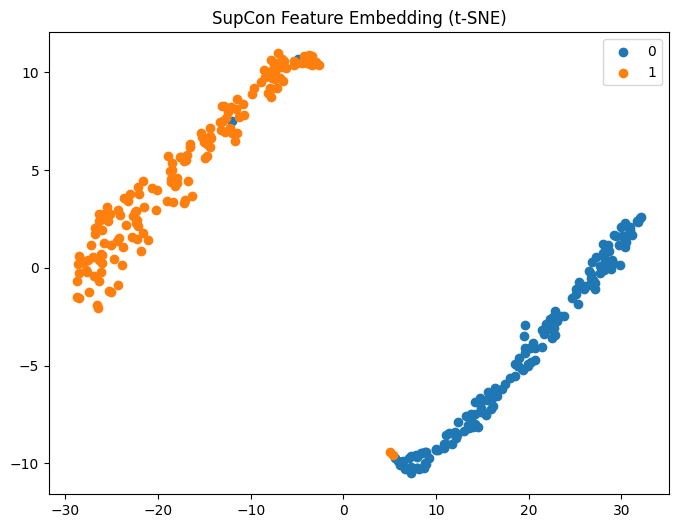

In [9]:
model.eval()
all_features, all_labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        features = model(x)
        all_features.append(features.cpu())
        all_labels.extend(y)

all_features = torch.cat(all_features).numpy()
all_labels = np.array(all_labels)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 6))
for label in np.unique(all_labels):
    idxs = all_labels == label
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=str(label))
plt.legend()
plt.title("SupCon Feature Embedding (t-SNE)")
plt.show()


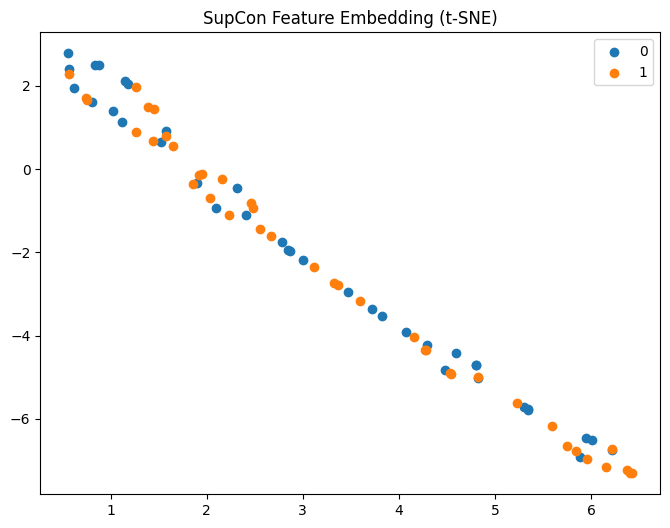

In [10]:
dataset = SimpleVideoDataset(X_test, y_test)
loader = DataLoader(dataset, batch_size=16, shuffle=True)
model.eval()
all_features, all_labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        features = model(x)
        all_features.append(features.cpu())
        all_labels.extend(y)

all_features = torch.cat(all_features).numpy()
all_labels = np.array(all_labels)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 6))
for label in np.unique(all_labels):
    idxs = all_labels == label
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=str(label))
plt.legend()
plt.title("SupCon Feature Embedding (t-SNE)")
plt.show()


# 分類訓練

In [11]:
# === 6. 分類模型（使用訓練好的 encoder）===
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder  # 預訓練好的 encoder（可選擇是否凍結）
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        return self.classifier(x)

In [12]:
# === 9. 微調分類器 ===
print("\n=== Fine-tuning Classifier ===")

# 初始化分類器，使用 encoder 的 feature extractor（不包含 projection head）
frozen_encoder = model.encoder
num_classes = len(set(y_list))
classifier_model = Classifier(frozen_encoder, num_classes).to(device)

# 解凍 encoder 可選：取消 with torch.no_grad() → 再訓練 encoder
optimizer_cls = torch.optim.Adam(classifier_model.classifier.parameters(), lr=1e-3)
criterion_cls = nn.CrossEntropyLoss()

classifier_model.train()
dataset = SimpleVideoDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

test_dataset = SimpleVideoDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for epoch in range(10):
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = classifier_model(x)
        loss = criterion_cls(logits, y)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"[CLS] Epoch {epoch} | Loss: {loss.item():.4f} | Acc: {acc:.2%}")

    with torch.no_grad():
        total, correct = 0, 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = classifier_model(x)
            loss = criterion_cls(logits, y)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = correct / total
        print(f"[CLS] Test | Loss: {loss.item():.4f} | Acc: {acc:.2%}")


=== Fine-tuning Classifier ===
[CLS] Epoch 0 | Loss: 0.6739 | Acc: 52.13%
[CLS] Test | Loss: 0.6932 | Acc: 51.95%
[CLS] Epoch 1 | Loss: 0.7201 | Acc: 63.61%
[CLS] Test | Loss: 0.6809 | Acc: 55.84%
[CLS] Epoch 2 | Loss: 0.6623 | Acc: 89.84%
[CLS] Test | Loss: 0.6897 | Acc: 54.55%
[CLS] Epoch 3 | Loss: 0.7243 | Acc: 94.10%
[CLS] Test | Loss: 0.6926 | Acc: 54.55%
[CLS] Epoch 4 | Loss: 0.6459 | Acc: 95.74%
[CLS] Test | Loss: 0.6940 | Acc: 54.55%
[CLS] Epoch 5 | Loss: 0.7447 | Acc: 95.41%
[CLS] Test | Loss: 0.6827 | Acc: 58.44%
[CLS] Epoch 6 | Loss: 0.6464 | Acc: 93.11%
[CLS] Test | Loss: 0.7128 | Acc: 53.25%
[CLS] Epoch 7 | Loss: 0.6209 | Acc: 95.41%
[CLS] Test | Loss: 0.6708 | Acc: 55.84%
[CLS] Epoch 8 | Loss: 0.6342 | Acc: 97.38%
[CLS] Test | Loss: 0.6946 | Acc: 58.44%
[CLS] Epoch 9 | Loss: 0.7608 | Acc: 95.08%
[CLS] Test | Loss: 0.6903 | Acc: 57.14%


[CLS] Test | Acc: 51.95%

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.2973    0.3729        37
           1     0.5273    0.7250    0.6105        40

    accuracy                         0.5195        77
   macro avg     0.5136    0.5111    0.4917        77
weighted avg     0.5142    0.5195    0.4963        77



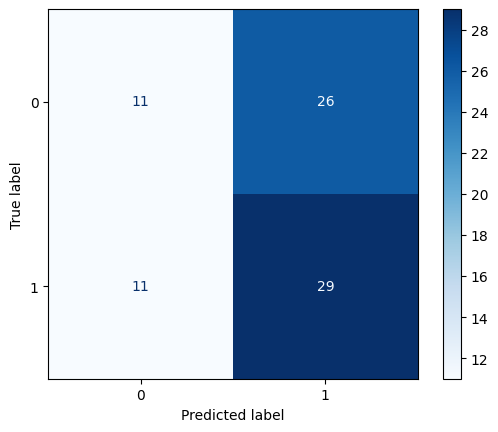

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 收集所有真實與預測標籤
all_preds, all_labels = [], []

with torch.no_grad():
    total, correct = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = classifier_model(x)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"[CLS] Test | Acc: {acc:.2%}")

# === 分類報告 ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# === 混淆矩陣 ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")  # 可換 colormap
